In [36]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import mplcyberpunk
from pylab import rcParams

plt.style.use("cyberpunk")
rcParams['figure.figsize'] = 20, 10

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import SCORERS

In [12]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

I choose Mean monthly temperature.

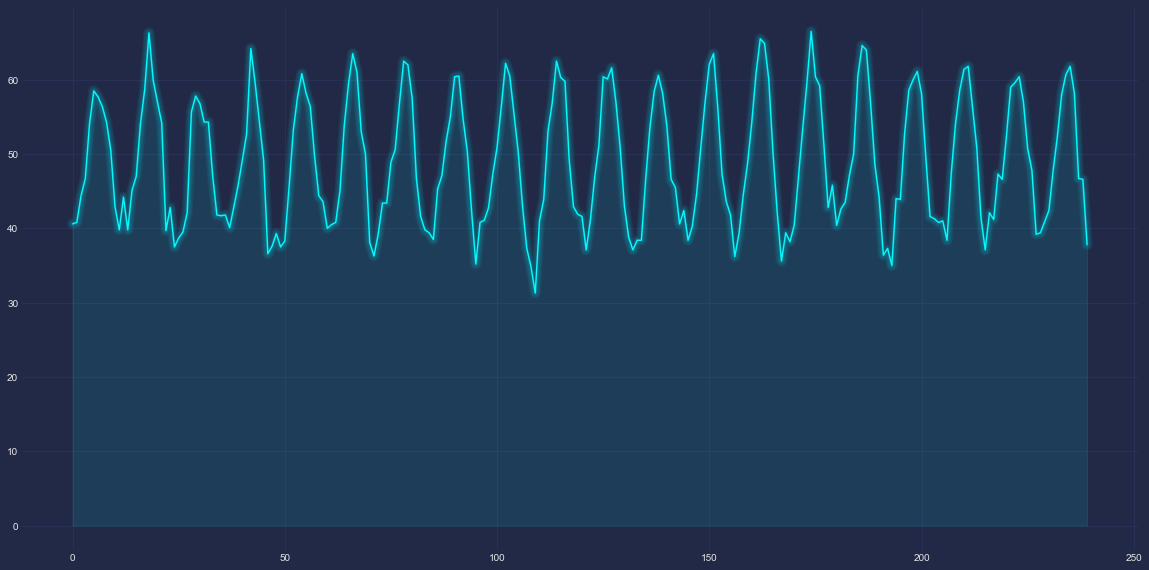

In [8]:
mean_monthly_temp = pd.read_csv("../mean-monthly-air-temperature-deg.csv")
series = mean_monthly_temp['Deg']
plt.plot(series)
mplcyberpunk.add_glow_effects()
plt.show()

In [9]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

D:\Python\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Python\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
D:\Python\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Python\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Python\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Python\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse 

aic: 1144.98314 | order: (2, 1, 4)


Results of Dickey-Fuller Test:
Test Statistic                  -5.581989
p-value                          0.000001
#Lags Used                       5.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


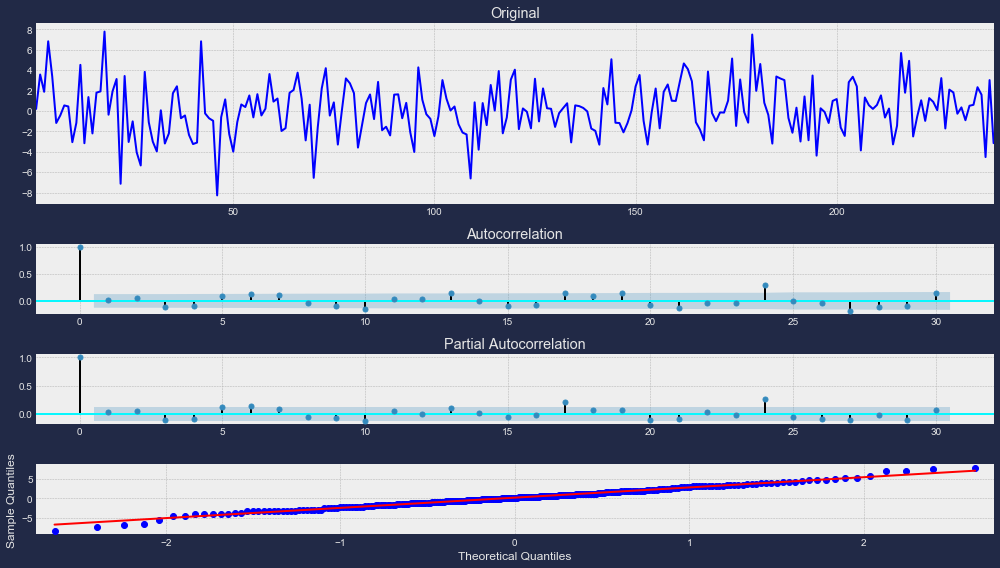

In [13]:
tsplot(best_mdl.resid, lags=30)

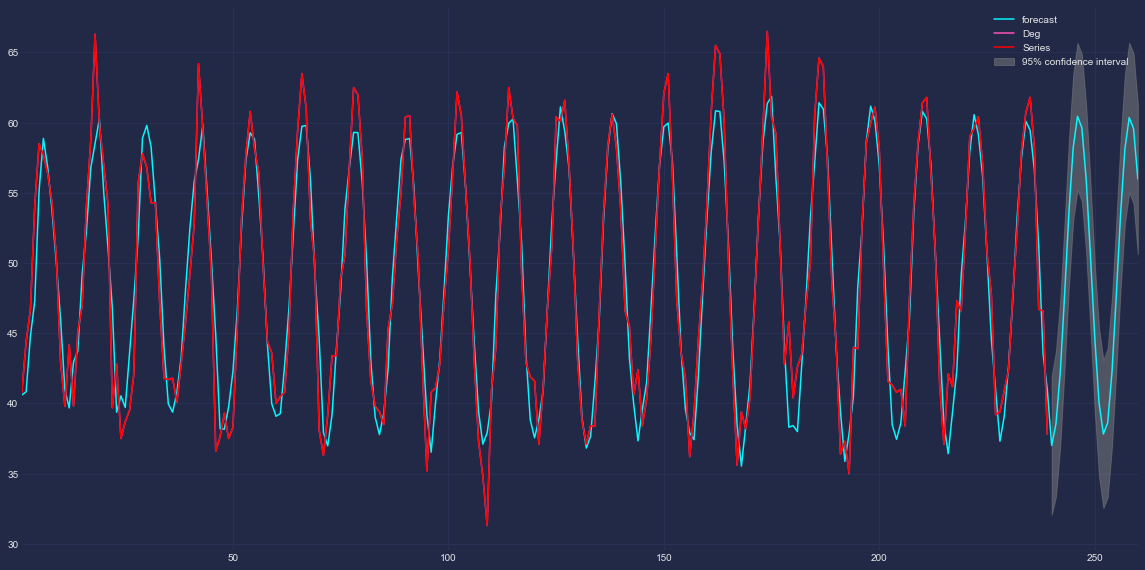

In [17]:
ax = plt.axes()
best_mdl.plot_predict(1, len(series)+20, ax=ax)
plt.plot(series, color='red', label='Series')
plt.legend()
plt.show()

This is much better, than TSE from previous homework.

# Classic ML

In [26]:
def prepareData(data, lag_start=5, lag_end=20):
    
    data = pd.DataFrame(data.copy())
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Deg.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
    
    X = data.drop(["Deg"], axis=1)
    y = data['Deg']
     
    return X, y

In [31]:
series = pd.read_csv("../mean-monthly-air-temperature-deg.csv")
X, y = prepareData(series, lag_start=1, lag_end=20)

In [38]:
alpha = list(range(1,1000))
alpha = [x*0.000001 for x in alpha]
rd = [42]
loss = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
penalty = ['l1', 'l2']
shuffle = [True, False]

param_grid = {'alpha': alpha, 'loss': loss, 'penalty': penalty, 'random_state': rd, 'shuffle': shuffle}

grid = GridSearchCV(SGDRegressor(), 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='neg_mean_squared_error',
                    n_jobs=-1)

grid.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_star...
                                   2.3e-05, 2.4e-05, 2.4999999999999998e-05,
                                   2.6e-05, 2.7e-05, 2.8e-05, 2.9e-05,
                                   2.9999999999999997e-05, ...],
                         'loss': ['squared_loss', 'huber',
                 

In [39]:
grid.best_estimator_

SGDRegressor(alpha=5.8e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='huber', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [40]:
grid.best_score_

-8.155411285236676

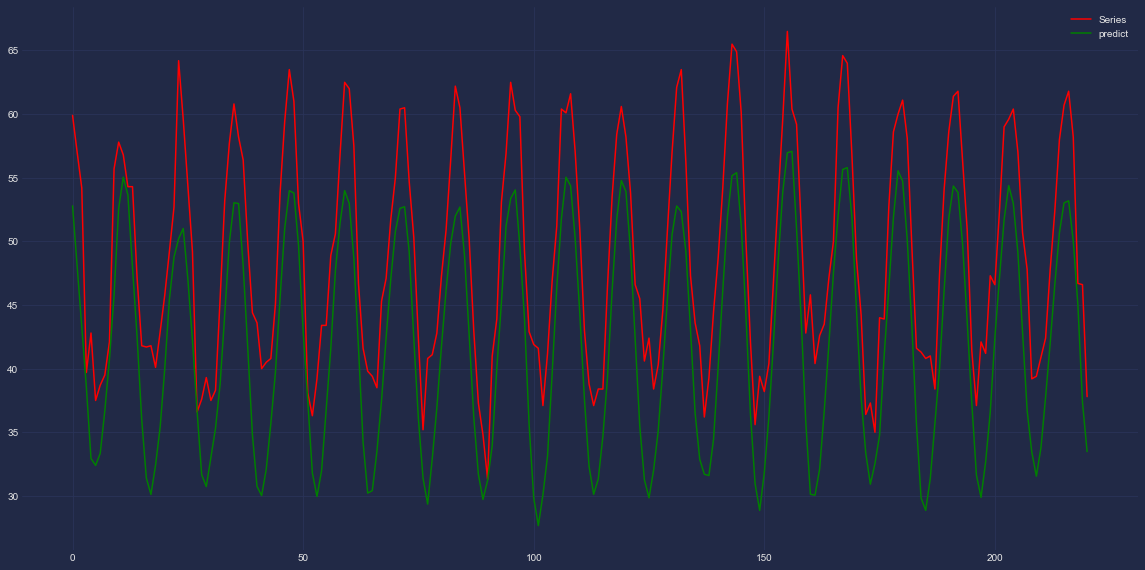

In [42]:
plt.plot(y, color='red', label='Series')
plt.plot(grid.best_estimator_.predict(X), color='green', label='predict')
plt.legend()
plt.show()

ARIMA better.